# Optimal Pricing Strategy

### The optimal price equation

For a given product with features $x$ (among them the cost $c$), let $f(x)$ be a pricing strategy. Let the demand at price $f$ of product $x$ be $D(x, f)$, which corresponds to the probability that the client purchases the product given the features $x$ and the set price $f$.

The expected revenue is $R = \mathbb E[f-c]$, where
$$\mathbb E[f-c] = \int dx (f(x)-c) D(x, f) P(x),$$
where $P(x)$ is the frequency with which a product with features $x$ is offered.

The optimal pricing must fullfill the optimality condition
$$
    \left.\frac{\delta \mathbb E[f-c]}{\delta f}\right|_{f=f^*} = \mathbb E\left[D(x, f^*) + (f^* - c)\left.\frac{\partial D}{\partial f}\right|_{f=f^*}\right] = 0
$$

where $\frac{\partial D}{\partial f}$ is the elasticity of the demand at price $f$.

This results in the **optimal price equation** for a given product with features $x$:
$$
    (f^*-c)\left.\frac{\partial D(x, f)}{\partial f}\right|_{f=f^*} + D(x, f^*) = 0
$$


This equation has no trivial solution and requires taiolerd numerical methods for each specific demand function $D(x, f)$

Since the optimal price equation is linear in $D$ we can replace the demand by its normalized value, i.e., the probability that a customer purchases the product at given features $x$ and set price $f$, $D(x, f) = P(\textrm{purchase}|x, f)$.

### Modelling demand with a logistic regression

For a logistic regression, this probability can be expressed as
$$
    D(x, f) = \frac{1}{1+\exp(-k^\top\cdot x - z - \gamma f)}
$$
where $x$ is the full set of features (excluding `bag_total_price`), $k$ are the associated model parameters and $z$ is the intercept.  

The elasticity then becomes
$$
    \frac{\partial D(x, f)}{\partial f} = D(x, f)(1-D(x, f))\gamma
$$
and the optimal price equation can be written as
$$
    (f^*(x)-c) (1-D(x, f^*(x)))\gamma + 1 = 0
$$

In [1]:
from src.benchmark import Benchmark
from src.models.baseline import LogisticRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.plots import prob_hist
from scipy.optimize import fsolve
from scipy.special import expit, logit
from matplotlib.colors import Normalize
from IPython.display import display

cmap = plt.colormaps["rainbow"]

import warnings

file_path = 'data/export.parquet'
df = pd.read_parquet(file_path)

# Define features and target variable
X = df.drop(['Bag_Purchased'], axis=1)
y = df['Bag_Purchased']

model = LogisticRegressor()

model.fit(X, y)

y_pred = model.pipeline.predict(X)

y_pred.mean(), model.model.intercept_[0]

/Users/amonras/.pyenv/versions/3.12.2/envs/kiwi/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.09634085213032581, -0.10855901653957076)

In [2]:
theta = pd.Series(model.model_coefficients())
intercept = model.model.intercept_ 

In [3]:
def price_utility_plot(data, ylabel):
    fig, ax = plt.subplots(figsize=(7, 3))
    plt.scatter(Z, data['price'], s=.1, color=cmap(data['demand']))
    ax.set_xlabel('Utility')
    ax.set_ylabel(ylabel)
    ax.plot(np.array([-1, 5]), -np.array([-1, 5])/gamma, 'k--', label='odds=1')
    ax.plot(np.array([-1, 5]), (logit(.25) - np.array([-1, 5]))/gamma, color = 'tab:gray', ls='--', label='odds=1/4')
    ax.set_title('Price vs utility')
    fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, 1), cmap=cmap), ax=ax)
    ax.set_xlim([-2, 4])
    ax.set_ylim([0, 150])
    ax.legend()
    fig.subplots_adjust(bottom=0.15)
    return fig

### Explore class imbalance

In [4]:
# Compute contrubutions from other features
X_transf = pd.DataFrame(
    model.pipeline.named_steps['preprocessor'].transform(X),
    columns = model.get_feature_names()
)
theta = pd.Series(model.model_coefficients())

# This is the full set of predictors, including the sell price
KX = X_transf.dot(theta).rename('kx') + intercept

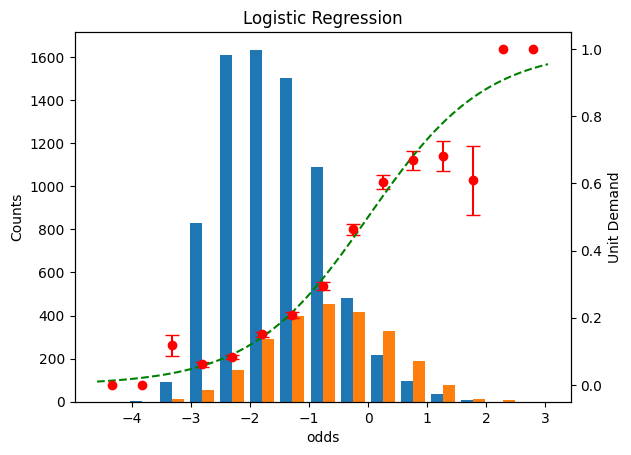

In [5]:
hist = prob_hist(
    predictor=KX,
    target=y,
    nbins=15
)
ax = hist.get_axes()

ax[0].set_title("Logistic Regression")
ax[1].set_ylabel("Unit Demand")
hist.savefig("images/odds.png")

In [6]:
# What's the predicted demand? (observed demand is 24%)
expit(KX).mean()

0.23926352262474962

### How well does the model predict the observed revenue?

In [7]:
actuals = pd.concat([X['bag_total_price'].rename('price'), y.rename('demand')], axis=1)

In [8]:
modeled = pd.DataFrame(dict(
    price = X['bag_total_price'].rename('optimal_price'),
    demand = expit(KX).rename('demand')
))

In [9]:
# Compute metrics for the model
cost = X['bag_base_price'].rename('cost')

results = pd.concat({
    "actuals": actuals, 
    "modeled": modeled
}, axis=1).astype(float)

def compute_extras(results):
    """
    Adds expecte revenue to dataframe
    """
    margin = results.xs('price', level=1, axis=1).add(-cost, axis='index')
    demand = results.xs('demand', level=1, axis=1)

    # Expected revenue
    exp_revenue = margin * demand

    # The Bernoulli variance
    variance = demand*(1 - demand)
    df = pd.concat(dict(
        exp_revenue = exp_revenue,
        variance = variance
    ), axis=1).reorder_levels([1, 0], axis=1)
    return pd.concat([results, df], axis=1)

def compute_summary(results):
    df = compute_extras(results).mean().unstack()
    styled = df.style\
        .format("{:.2f}")\
        .format('{:.2f}€', subset=["exp_revenue", "price"])\
        .format("{:.2%}", subset=['demand'])
    return styled

compute_summary(results)


,demand,exp_revenue,price,variance
actuals,23.90%,4.95€,64.62€,0.00
modeled,23.93%,4.95€,64.62€,0.15


The correctly model predicts the demand, expected revenue and average price

## Prepare the optimal price equation

Let's compute the contribution of all features, leaving aside the contribution from the total price. According to our model, the demand function is given by
$$
    D(x, f) = \textrm{expit}(Z + \gamma f)
$$
where we will call $Z=k^\top x + \textrm{intercept}$ **the utility**. 

The cost $c=$ `bag_base_price` should not be a part of the feature vector $x$. It is already filtered out by the pipeline in `X_transf`.

In [10]:
assert 'bag_base_price' not in theta.keys()

In [11]:
Z = (X_transf.drop('bag_total_price', axis=1).dot(theta.drop('bag_total_price')) + intercept).rename('kx')
gamma = theta['bag_total_price']

gamma

-0.026134070295815152

As expected the elasticity is negative, more price translates to lower demand

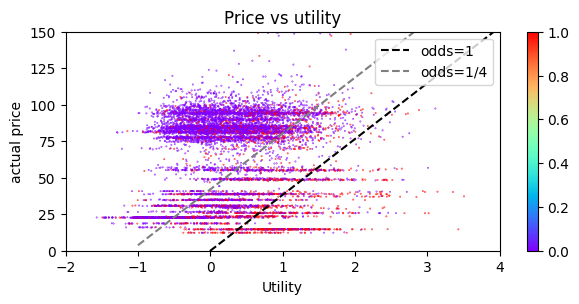

In [12]:
fig = price_utility_plot(actuals.astype(float), ylabel='actual price')
fig.savefig("images/price_vs_utility.png")

In [13]:
def optimal_price_equation(f, c, z, g):
    return g * (f - c) * (1 - expit(z + g * f)) + 1
    
def optimize(cost, Z):
    return fsolve(optimal_price_equation, x0=1.5 * cost, args=(cost, Z, gamma))[0]

In [14]:
price = pd.concat([cost, Z], axis=1).apply(
        lambda row: optimize(row['cost'], row['kx']),
    axis=1).rename('price')
prob = expit(Z + gamma * price)
optimal = pd.DataFrame({"price": price, "demand": prob})


results = pd.concat({
    "actuals": actuals, 
    "modeled": modeled,
    "optimal": optimal
}, axis=1).astype(float)

results.sample(10)

actuals           modeled              optimal          
          price demand      price    demand      price    demand
5972  81.804001    0.0  81.804001  0.101242  89.874890  0.083599
4174  80.733002    1.0  80.733002  0.178279  91.947059  0.139299
5209  83.571999    0.0  83.571999  0.116008  91.505433  0.096379
3275  76.669998    0.0  76.669998  0.227193  91.082741  0.167857
5945  84.201004    1.0  84.201004  0.081247  90.652939  0.069516
7128  77.281998    0.0  77.281998  0.103371  87.134261  0.081826
7213  90.372002    0.0  90.372002  0.153743  97.234521  0.131829
6635  14.552001    1.0  14.552001  0.475320  57.969712  0.225573
7475  92.701004    0.0  92.701004  0.081298  95.908086  0.075254
8716  94.010002    0.0  94.010002  0.121486  98.295053  0.110032

In [15]:
compute_summary(results)

,demand,exp_revenue,price,variance
actuals,23.90%,4.95€,64.62€,0.00
modeled,23.93%,4.95€,64.62€,0.15
optimal,15.15%,7.38€,83.65€,0.12


In [16]:
# DEPRECATED

# warnings.filterwarnings('ignore', 'The iteration is not making good progress')

optimal_price = pd.concat([cost, Z], axis=1).apply(
    lambda row: optimize(row['cost'], row['kx']),
    axis=1
).rename('optimal_price')

res = pd.concat([
    X[['bag_base_price', 'bag_total_price', 'price']], 
    y, 
    optimal_price
], axis=1)

# Add the success probability at optimal price
res['prob'] = expit(Z + gamma * res['optimal_price'])

# Add expected revenue
res['exp_revenue'] = (res['optimal_price'] - res['bag_base_price'])*res['prob']
res['actual_revenue'] = (res['bag_total_price'] - res['bag_base_price'])*res['Bag_Purchased']
res.sample(8)

,bag_base_price,bag_total_price,price,Bag_Purchased,optimal_price,prob,exp_revenue,actual_revenue
2073,15.730000,26.740999,61.43,False,64.042416,0.207984,10.048190,0.000000
9338,54.700001,92.990005,186.70,False,100.027536,0.155828,7.063308,0.000000
1311,13.440000,22.848000,49.50,False,62.657391,0.222547,10.953165,0.000000
6878,20.440001,34.748001,73.60,False,67.138239,0.180607,8.434011,0.000000
3160,56.400002,95.880005,205.96,False,97.731081,0.074202,3.066852,0.000000
6817,7.270000,12.359000,138.92,True,55.792533,0.211413,10.258306,5.089000
1290,23.469999,39.898998,180.98,True,74.473289,0.249769,12.739063,16.428999
9576,55.700001,94.690002,111.35,False,96.030976,0.051245,2.066748,0.000000


In [17]:
res.mean()

bag_base_price      38.009509
bag_total_price     64.616167
price              106.072021
Bag_Purchased        0.238997
optimal_price       83.651846
prob                 0.151489
exp_revenue          7.378110
actual_revenue       4.949967
dtype: float64

### Explore results

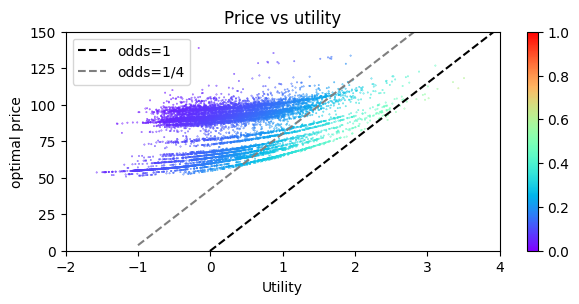

In [18]:
# Look at the price-utility trend
fig = price_utility_plot(optimal, ylabel='optimal price')
fig.savefig("images/optimal_vs_utility.png")

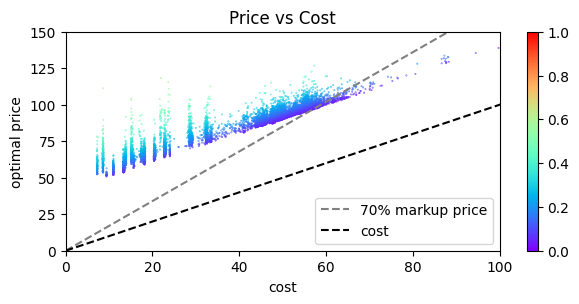

In [19]:
def price_cost_plot(data, ylabel):
    fig, ax = plt.subplots(figsize=[7, 3])
    ax.scatter(cost, data['price'], s=.1, color=cmap(data['demand']))
    ax.set_xlabel('cost')
    ax.set_ylabel(ylabel)
    line = np.array([0, 150])
    ax.plot(line, 1.7 * line, c='gray', ls='--', label='70% markup price')
    ax.plot(line, line, 'k--', label='cost')
    fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, 1), cmap=cmap), ax=ax)
    
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 150])
    ax.set_title("Price vs Cost")
    ax.legend()
    fig.subplots_adjust(bottom=0.15)
    
    return fig
fig = price_cost_plot(optimal, ylabel='optimal price')
fig.savefig("images/optimal_vs_cost.png")

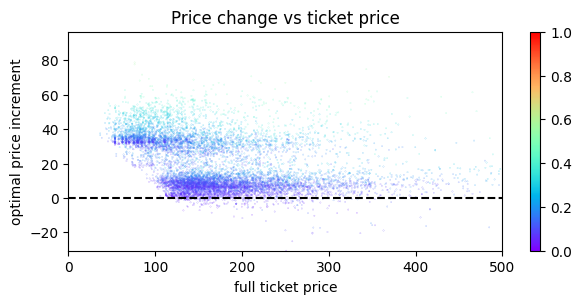

In [48]:
def price_change_plot(data, model):
    fig, ax = plt.subplots(figsize=[7, 3])
    
    x = X['price'] + X['bag_total_price']
    y = X['price'] + data['price'] - x
    ax.scatter(x, y, label='demand', s=.01, c=cmap(data['demand']))
    # ax.scatter(x[~y], results['price'][~y] + results['optimal_price'][~y] - x[~y], label='not purchased', s=.01)
    ax.set_xlabel('full ticket price')
    ax.set_ylabel(f'{model} price increment')
    ax.plot([0, 600], [0, 0], 'k--')
    ax.set_xlim([0, 500])

    ymax = y.max()
    ymin = y.min()
    ax.set_ylim([ymin, ymax])
    fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, 1), cmap=cmap), ax=ax)
    ax.set_title("Price change vs ticket price")
    fig.subplots_adjust(bottom=0.15)
    return fig

fig = price_change_plot(optimal, model='optimal')
fig.savefig("images/optimal_change.png")

## Constrained optimization formulation


We need to maximize the profit subject to keeping the demand above a certain threshold

$$
\begin{align}
    & \textrm{maximize}_{f(x)} & &\mathbb{E}\left[(f(x) - c) D(x, f(x)\right]\\
    & \textrm{subject~to} & & \mathbb{E}\left[D(x, f(x))\right] > k
\end{align}
$$

We'll use a soft constraint for this optimization
$$
\begin{align}
    L[f] = \mathbb{E}\left[(c-f(x) - \lambda) D(x, f(x)\right] + e^{\lambda(k - \mathbb{E}[D(x, f(x)])}
\end{align}
$$


In [27]:
# Set the target demand as the current
k = y.mean()

# Set a strong penalty
lamb = 100

In [28]:
import numpy as np
from scipy.optimize import minimize


In [29]:
# Define the Lagrangian

# Function to be minimized
def L(f):
    # The array of probabilities
    prob = expit(Z + gamma * f(Z, cost))

    # The constraint. Should be negative
    constraint = (k - prob.mean()) 

    # The objective function with an exponential penalty
    out = ((cost - f(Z, cost)) * prob).mean() + np.exp(lamb * constraint)
    return out

# Define a quadratic function f(z, cost)
def func(z, cost, a, b, c, d, e, f):
    return a*z**2 + b * z * cost + c * cost** 2 + d * z + e * cost + f

# Define the objective
def objective(params):
    a, b, c, d, e, f = params
    return L(lambda z, cost: func(z, cost, a, b, c, d, e, f))

# Initial guess for the parameters a, b, c, d, e, f
initial_guess = [1/np.power(Z, 2).mean(), 1/(Z * cost).mean(), 1/np.power(cost, 2).mean(), 1/Z.mean(), 1/cost.mean(), .1]

# Call the minimize function
res = minimize(objective, initial_guess, method='Nelder-Mead')

# Use this result as a starting point for a new iteration
res = minimize(objective, res.x)

In [30]:
res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -5.354686211403066
        x: [ 2.611e+00 -1.371e-01  1.800e-03  1.304e+01  6.587e-01
             2.524e+01]
      nit: 45
      jac: [ 2.384e-07  9.835e-06  8.348e-04  1.788e-07  1.848e-05
             6.557e-07]
 hess_inv: [[ 1.514e+02 -2.713e+00 ... -3.417e+01  4.301e+02]
            [-2.713e+00  3.103e+00 ... -1.147e+01  2.040e+02]
            ...
            [-3.417e+01 -1.147e+01 ...  5.942e+01 -9.887e+02]
            [ 4.301e+02  2.040e+02 ... -9.887e+02  1.695e+04]]
     nfev: 420
     njev: 60

In [31]:
F = lambda z, cost: func(z, cost, *res.x)

In [32]:
price = F(Z, cost).rename('price')
demand = expit(Z + gamma * price).rename('demand')
constrained = pd.concat([price, demand], axis=1)
constrained.head()

,price,demand
0,29.717938,0.140309
1,68.614910,0.120878
2,50.920328,0.219968
3,26.789972,0.176580
4,66.220665,0.287527


In [33]:
results = pd.concat(dict(
    actuals = actuals,
    modeled = modeled,
    optimal = optimal,
    constrained = constrained
), axis=1)

compute_summary(results)

,demand,exp_revenue,price,variance
actuals,23.90%,4.95€,64.62€,0.00
modeled,23.93%,4.95€,64.62€,0.15
optimal,15.15%,7.38€,83.65€,0.12
constrained,25.01%,5.68€,57.26€,0.18


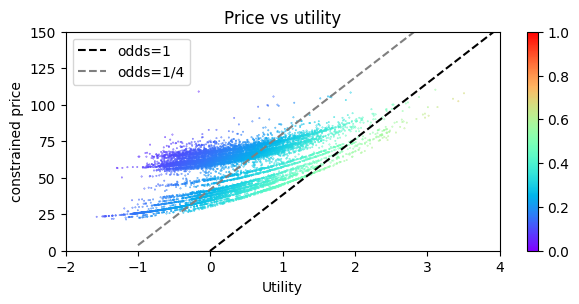

In [34]:
fig = price_utility_plot(constrained, ylabel='constrained price')
fig.savefig("images/constrained_utility.png")

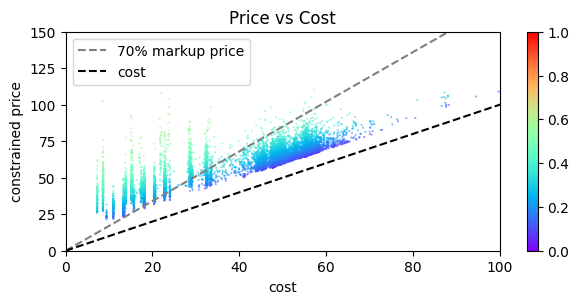

In [35]:
fig = price_cost_plot(constrained, ylabel='constrained price')
fig.savefig("images/constrained_cost.png")

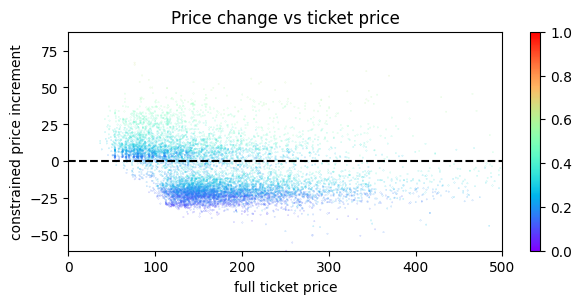

In [36]:
fig = price_change_plot(constrained, model='constrained')
fig.savefig("images/constrained_change.png")

In [37]:
(constrained['price']/cost - 1).describe()

count    9975.000000
mean        0.824791
std         0.953072
min         0.093021
25%         0.266800
50%         0.416064
75%         1.041175
max        10.893330
dtype: float64

(0.0, 200.0)

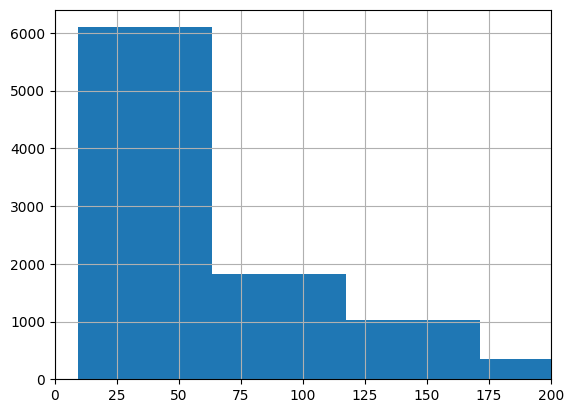

In [38]:
fig = (100*(constrained['price']/cost - 1)).hist(bins=20)
fig.set_xlim([0, 200])

## Risk analysis

In [45]:
compute_summary(results)

,demand,exp_revenue,price,variance
actuals,23.90%,4.95€,64.62€,0.00
modeled,23.93%,4.95€,64.62€,0.15
optimal,15.15%,7.38€,83.65€,0.12
constrained,25.01%,5.68€,57.26€,0.18


In [46]:
# Let's compute the expected fluctuations for each model

# Enrich results with extra metrics
rich_results = compute_extras(results)

summary = {}

for model in rich_results.columns.get_level_values(level=0).unique():
    res = rich_results.xs(model, level=0, axis=1)

    mean = res.mean()
    mean['std'] = np.sqrt(mean['variance'])

    print(f"Variance for model {model}")
    print(f"Expected revenue per flight is going to be {mean['exp_revenue']:.2f}€ +/- {mean['std']:.2f}€")
    print(f"Total expected revenue in the period is going to be {mean['exp_revenue']*len(res):.0f}€ +/- {mean['std']*len(res):.0f}€")
    print(f"68% (1-sigma) Confidence interval is [{(mean['exp_revenue'] - mean['std'])*len(res):.0f}€, {(mean['exp_revenue'] + mean['std'])*len(res):.0f}€]")
    print(f"95% (2-sigma) Confidence interval is [{(mean['exp_revenue'] - 2*mean['std'])*len(res):.0f}€, {(mean['exp_revenue'] + 2*mean['std'])*len(res):.0f}€]")

    summary[model] = mean

summary = pd.concat(summary, axis=1)

summary

Variance for model actuals
Expected revenue per flight is going to be 4.95€ +/- 0.00€
Total expected revenue in the period is going to be 49376€ +/- 0€
68% (1-sigma) Confidence interval is [49376€, 49376€]
95% (2-sigma) Confidence interval is [49376€, 49376€]
Variance for model modeled
Expected revenue per flight is going to be 4.95€ +/- 0.39€
Total expected revenue in the period is going to be 49328€ +/- 3904€
68% (1-sigma) Confidence interval is [45424€, 53231€]
95% (2-sigma) Confidence interval is [41520€, 57135€]
Variance for model optimal
Expected revenue per flight is going to be 7.38€ +/- 0.35€
Total expected revenue in the period is going to be 73597€ +/- 3474€
68% (1-sigma) Confidence interval is [70123€, 77071€]
95% (2-sigma) Confidence interval is [66649€, 80545€]
Variance for model constrained
Expected revenue per flight is going to be 5.68€ +/- 0.42€
Total expected revenue in the period is going to be 56698€ +/- 4195€
68% (1-sigma) Confidence interval is [52503€, 60893€]
9

,actuals,modeled,optimal,constrained
price,64.616167,64.616167,83.651846,57.262908
demand,0.238997,0.239264,0.151489,0.250105
exp_revenue,4.949967,4.945124,7.378110,5.684013
variance,0.000000,0.153168,0.121289,0.176870
std,0.000000,0.391367,0.348266,0.420559


### Use bootstrap to confirm volatility estimates

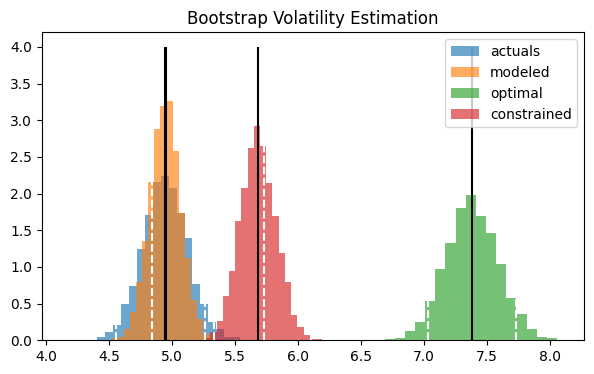

In [47]:
N = 5000
model = 'actuals'

def bootstrap_revenue(results):
    rev = []
    for i in range(N):
        sample = results.sample(len(results), replace=True)                            
        purchased = sample['demand'] > np.random.sample(sample.shape[0])
        revenue = (sample['price'] - cost) * purchased
        rev.append(revenue.mean())
    return pd.Series(rev)


rev = {}

for model in rich_results.columns.get_level_values(level=0).unique():
    rev[model] = bootstrap_revenue(results.xs(model, level=0, axis=1))
#fig = plt.hist(rev, bins=20)

ymax = 4
df = pd.concat(rev, names=['model']).reset_index()
fig, ax = plt.subplots(figsize=[7, 4])

for g in pd.unique(df['model']):
    p = df.loc[df['model']==g, 0].hist(bins=20,
                                   alpha=0.65,
                                   label=g,
                                   density=True)
    c = p.get_facecolor()
    plt.vlines(summary.loc['exp_revenue', g], ymin=0, ymax=ymax, colors='black')
    if g == 'actuals':
        # Don't plot sigmas
        continue
        
    plt.vlines((summary.loc['exp_revenue', g] + summary.loc['std', g]), ymin=0, ymax=ymax, colors=c, linestyles='--')
    plt.vlines((summary.loc['exp_revenue', g] - summary.loc['std', g]), ymin=0, ymax=ymax, colors=c, linestyles='--')
    plt.vlines((summary.loc['exp_revenue', g] + 2 * summary.loc['std', g]), ymin=0, ymax=ymax, colors=c, linestyles='--')
    plt.vlines((summary.loc['exp_revenue', g] - 2 * summary.loc['std', g]), ymin=0, ymax=ymax, colors=c, linestyles='--')

    
plt.grid(False)
plt.legend(loc='upper right')
plt.title("Bootstrap Volatility Estimation")
fig.savefig("images/revenue_histograms.png")


### Volume projections

In [43]:
results.mean().unstack()

,price,demand
actuals,64.616167,0.238997
modeled,64.616167,0.239264
optimal,83.651846,0.151489
constrained,57.262908,0.250105


We see that the total number of bags purchased would drop from 24% to 15%. Perhaps this is unacceptable

## Use duality

In [39]:
# Find optimal lambda for a given f

def optimize_slack(f):
    # Find the optimal value for the slack variable
    # return argmax_lambda L[f, lambda]

    # If the constrained is not satisfied the optimization returns infinite
    if expit(Z + gamma * f(Z, cost)).mean() < k:
        return np.inf

    # Define the objective
    def objective(lamb):
        return -L(f, lamb[0])
    
    # Optimize for lambda
    res = minimize(objective, [.1], bounds=[(0, np.inf)])

    val = -objective(res.x)
    
    print(f"The Lagrangian is maximized at lambda={res.x[0]:.4f} with value {val:.4f}")

    return val

# As an example:

def f(z, cost):
    return z**2 - 8*z + 72 - cost

optimize_slack(f)

TypeError: L() takes 1 positional argument but 2 were given

In [ ]:
# Find the optimal f(Z) that minimizes the Lagrangian sup_lambda L[f(x), lambda]

# Define a quadratic function f(z, cost)
def func(z, cost, a, b, c, d, e, f):
    return a*z**2 + b * z * cost + c * cost** 2 + d * z + e * cost + f

# Define the objective function to minimize (sum of squared residuals)
def objective(params):
    a, b, c, d, e, f = params
    def F(z, cost):
        return func(z, cost, a, b, c, d, e, f)
    lamb = optimize_slack(F)
    return L(F, lamb)

# Initial guess for the parameters a, b, c, d, e, f
initial_guess = [0, 0, 0, 0, .1, .1]

# Call the minimize function
res = minimize(objective, initial_guess)

# Print the result
print(f"The optimal function has parameters {res.x}")
print(res)
objective(res.x)